<center>
<a href="http://keras.io"><img src='keras-logo.jpg'></a>
<h1>Introduction to Deep Learning with Keras</h1>
<h2>Michela Paganini - Yale University</h2>
<a href='https://indico.cern.ch/event/487416/'>
<h4>2nd Developers@CERN Forum - Python at CERN</h4></a>
</center>

### Load and Plot Data

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

I usually like to collect similar functions in a module. `pandautils` groups together some of the short utility functions we saw in the other notebook. They can all be seen as shortcuts for data handling using `pandas` dataframes.

In [2]:
import pandautils as pup

In [3]:
# -- load data into dataframes
# MC signal:
ttbar = pup.root2panda('HEPTutorial/files/ttbar.root', 'events') 
# MC backgrounds:
dy = pup.root2panda('HEPTutorial/files/dy.root', 'events')
wj = pup.root2panda('HEPTutorial/files/wjets.root', 'events')
ww = pup.root2panda('HEPTutorial/files/ww.root', 'events')
wz = pup.root2panda('HEPTutorial/files/wz.root', 'events')
zz = pup.root2panda('HEPTutorial/files/zz.root', 'events')
singletop = pup.root2panda('HEPTutorial/files/single_top.root', 'events')
qcd = pup.root2panda('HEPTutorial/files/qcd.root', 'events')
# data:
data = pup.root2panda('HEPTutorial/files/data.root', 'events')

All samples except from the ttbar one are produced using muon trigger. To enforce that on the ttbar sample as well, we use the branch called `triggerIsoMu24` which contains a boolean to indicate if any event would have passed the specified trigger. 

In [4]:
ttbar = ttbar[ttbar['triggerIsoMu24']].reset_index(drop=True)

Let's say we want to start by training a simple model that only relies on event-level variables. The ones available in these samples are:

In [5]:
npart = ['NJet', 'NMuon', 'NElectron', 'NPhoton', 'MET_px', 'MET_py']

If you are a physicist, the first thing you might want to do is to plot them. We do so very easily using `matplotlib`:

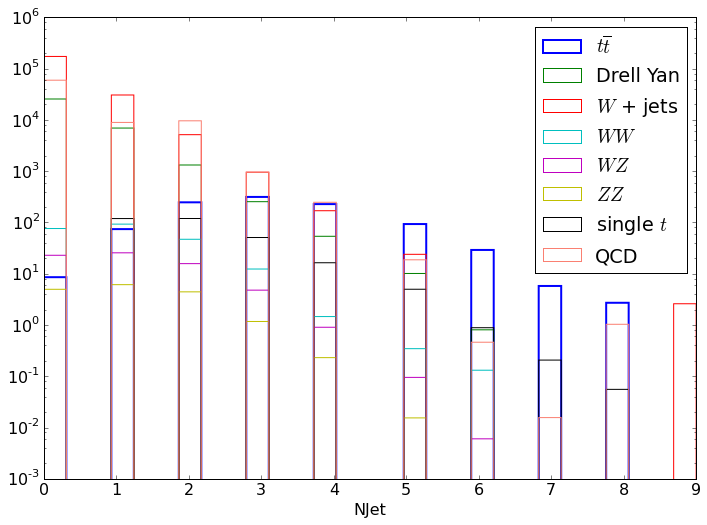

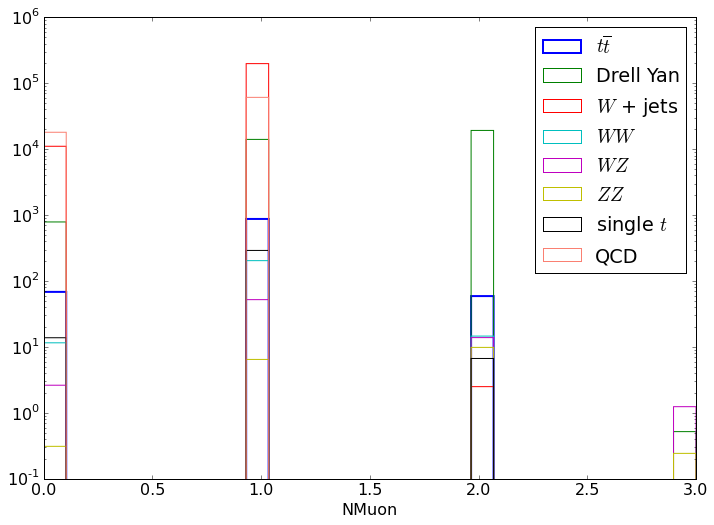

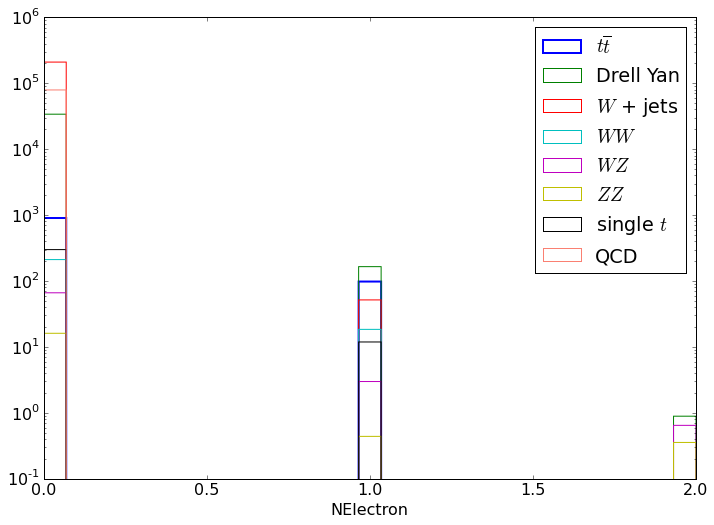

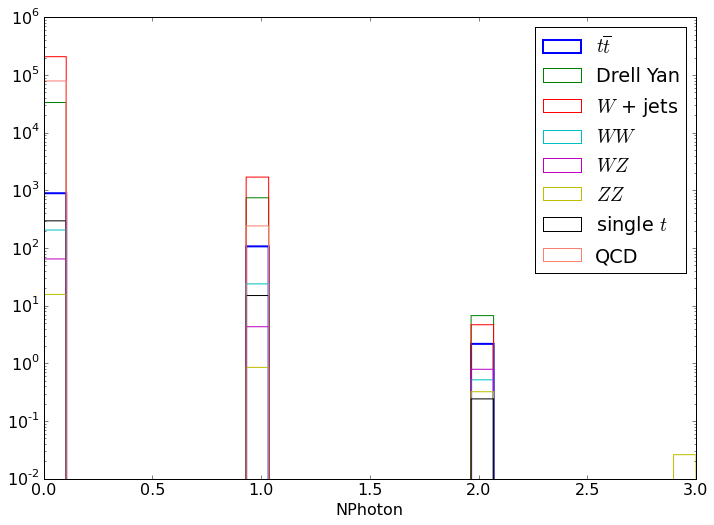

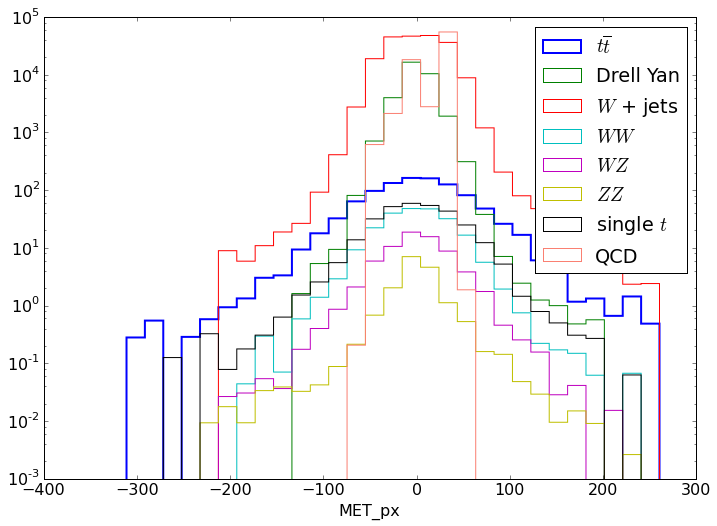

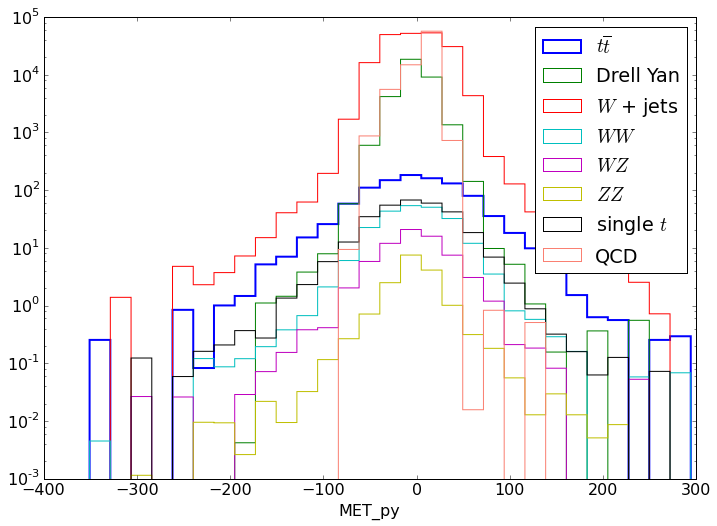

In [6]:
for key in npart:
    
    # -- set font and canvas size
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
    
    # -- declare common binning strategy
    bins=np.linspace(min(ttbar[key]), max(ttbar[key]) + 1, 30)
    
    _ = plt.hist(ttbar[key], histtype='step', normed=False, bins=bins, weights=ttbar['EventWeight'], label=r'$t\overline{t}$', linewidth=2)
    _ = plt.hist(dy[key], histtype='step', normed=False, bins=bins, weights=dy['EventWeight'], label='Drell Yan')
    _ = plt.hist(wj[key], histtype='step', normed=False, bins=bins, weights=wj['EventWeight'], label=r'$W$ + jets')
    _ = plt.hist(ww[key], histtype='step', normed=False, bins=bins, weights=ww['EventWeight'], label=r'$WW$')
    _ = plt.hist(wz[key], histtype='step', normed=False, bins=bins, weights=wz['EventWeight'], label=r'$WZ$')
    _ = plt.hist(zz[key], histtype='step', normed=False, bins=bins, weights=zz['EventWeight'], label=r'$ZZ$')
    _ = plt.hist(singletop[key], histtype='step', normed=False, bins=bins, weights=singletop['EventWeight'], label=r'single $t$')
    _ = plt.hist(qcd[key], histtype='step', normed=False, bins=bins, weights=qcd['EventWeight'], label='QCD', color='salmon')
    
    plt.xlabel(key)
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()

## Turn Data into ML-Compatible Inputs

#### What are ML-Compatible Inputs?

Keras, just like scikit-learn, takes as inputs the following objects:
 *  <h3>$X$</h3>
 an `ndarray` of dimensions `[nb_examples, nb_features]` containing the distributions to be used as inputs to the model. Each row is an object to classify, each column corresponds to a specific variable.
 *  <h3>$y$</h3>
 an `array` of dimensions `[nb_examples]` containing the truth labels indicating the class each object belongs to (for classification), or the continuous target values (for regression).
 *  <h3>$w$</h3> 
 (optional) an `array` of dimensions `[nb_examples]` containing the weights to be assigned to each example
 
The indices of these objects must map to the same examples. In general, you will want to shuffle and split them into a training and test set.

#### Let's do it!

If we want to stack multiple dataframes into a single one, we can "concatenate" them. To simplify our classification problem, in this tutorial I will only focus on a three-class classification task, in which we aim to separate TTbar events from two of the main background sources: Drell Yan and W+jets events.

In [7]:
# -- this will only contain TTbar, Drell Yan and W+jets events (all branches)
df_full = pd.concat((ttbar, dy, wj), ignore_index=True)  

However, we decided we were only going to train on event-level variables, so this is would be a more useful `df`:

In [8]:
df =  pd.concat((ttbar[npart], dy[npart], wj[npart]), ignore_index=True)
df

,NJet,NMuon,NElectron,NPhoton,MET_px,MET_py
0,3,1,0,0,20.238705,1.876128
1,5,1,0,0,-29.892015,16.498444
2,5,1,0,0,-24.056999,-46.160618
3,3,1,0,0,-30.039965,5.851555
4,3,1,0,0,4.518302,117.570068
5,4,2,0,0,-96.077881,21.859945
6,4,0,0,0,14.767733,-6.190931
7,0,1,0,0,-6.708472,-38.952297
8,3,1,0,0,91.455719,0.633036
9,3,1,0,0,-273.818817,112.582359


Now, turn your new `df` the desired ndarray $X$ that can be directly used for ML applications using this handy `pandas` function:

In [9]:
X = df.as_matrix()

The weight array $w$ can also easily be extracted using a similar procedure:

In [10]:
w =  pd.concat((ttbar['EventWeight'], dy['EventWeight'], wj['EventWeight']), ignore_index=True).values

Finally, generate an array of truth labels $y$ to distinguish among the different classes in the problem:

In [11]:
y = []
for _df, ID in [(ttbar, 0), (dy, 1), (wj, 2)]:
    y.extend([ID] * _df.shape[0])
y = np.array(y)

#### Extra Pre-Processing Steps: Shuffling, Splitting into Train-Test, Scaling Inputs

The `sklearn` function <a href='http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html'>`train_test_split`</a> will randomly shuffle and automatically split all your objects into train and test subsets.

In [12]:
from sklearn.cross_validation import train_test_split

ix = range(X.shape[0]) # array of indices, just to keep track of them for safety reasons and future checks
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.6)

It is common practice to scale the inputs to Neural Nets such that they have approximately similar ranges. Without this step, you might end up with variables whose values span very different orders of magnitude. This will create problems in the NN convergence due to very wild fluctuations in the magnitude of the internal weights. To take care of the scaling, we use the `sklearn` `StandardScaler`:
<a href='http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html'><img src='standardscaler.jpg' style="width:800px"></a>

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training a NN using Keras

### Neural Netwroks

 *  Stack of tensor operators
 *  Series of linear and non-linear transformations with the goal of finding optimal parameters to transform inputs and approximate targets
 *  Deep nets > shallow nets

## 1. Multilayer Perceptron (MLP)

<h3>Dense</h3>
 *  Core layer of an MLP
 *  Linear transformation of the input vector $x \in \mathbb{R}^n$, which can be expressed using the $n \times m$ matrix $W \in \mathbb{R}^{n \times m}$ as:
<center> $u = Wx + b$ </center>
where $b \in \mathbb{R}^m$ is the bias unit

 *  All entries in both $W$ and $b$ are trainable
 *  In Keras:
 ```
 keras.layers.core.Dense(
                             output_dim, 
                             init='glorot_uniform', 
                             activation='linear', 
                             weights=None, 
                             W_regularizer=None, 
                             b_regularizer=None,
                             activity_regularizer=None, 
                             W_constraint=None, 
                             b_constraint=None, 
                             input_dim=None
                           )```

 *  `input_dim` (or `input_shape`) are necessary arguments for the 1st layer of the net
<img src='dense.jpg' style='width:800px'>



<h3>Activation Functions</h3>
 *  Mathematical way of quantifying the activation state of a node $\rightarrow$ whether it's firing or not
 *  Non-linear activation functions are the key to Deep Learning
 *  Allow NNs to learn complex, non-linear transformations of the inputs
 *  Some popular choices:
 <img src='activations_table.jpg' style='width:700px'>
 <img src='activation.jpg' style='width:800px'>
 <img src='activation2.jpg' style='width:800px'>

<h3>Regularization</h3>
 *  Series of methods to avoid overfitting
 *  Mathematical encouragement towards simpler models
 *  Explicitly penalize weights that get too large
 *  Two main categories: 
 <img src='regtypes.jpg' style='width:700px'>
 *  In Keras, Dropout is added in as a layer. It masks the outputs of the previous layer such that some of them will randomly become inactive and will not contribute to information propagation:
  <img src='dropout.jpg' style='width:800px'>


In [15]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

Using Theano backend.


In [25]:
model = Sequential()

model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.2))

Let's add some fancier layers!

<h3>Highway</h3>
 *  LSTM-inspired fully connected layer
 *  Use adaptive gating units which learn to regulate the flow of information through a network
 *  Improves ability to train very deep feed-forward nets
 *  Introduced in 2015 by the IDSIA Lab (http://arxiv.org/pdf/1507.06228v2.pdf)

<h3>Maxout</h3>
 *  A Dense layer that learns its own activation function
 *  In Keras:
 <img src='maxout.jpg' style='width:800px'>

In [26]:
from keras.layers import Highway, MaxoutDense

In [27]:
model.add(Highway(activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='relu'))
model.add(MaxoutDense(5, 4))
model.add(Dense(3, activation='softmax'))
# last layer has to have the same dimensionality as the number of classes we want to predict, here 3

In [28]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dense_8 (Dense)                    (None, 10)          70          dense_input_2[0][0]              
____________________________________________________________________________________________________
dropout_6 (Dropout)                (None, 10)          0           dense_8[0][0]                    
____________________________________________________________________________________________________
dense_9 (Dense)                    (None, 20)          220         dropout_6[0][0]                  
____________________________________________________________________________________________________
dropout_7 (Dropout)                (None, 20)          0           dense_9[0][0]                    
___________________________________________________________________________________________

Satisfied with your net?

Now you need to declare what loss function and optimizer to use. We pass these as arguments to `compile`:

In [29]:
model.compile('adam', 'sparse_categorical_crossentropy') 

<h3>Forward Propagation</h3>
 * Sequential series of operations
 * Transforms input vector of features $x$ through the layers on the NN to obtain the final output $\hat{y}$
 * $\hat{y}$ depends not only on the input vector $x$ but also on the current values of the weights in each layer
 * A sequential model with $L$ layers is simply computing:
 $$
\hat{y} = f^{(L)}(z_{L - 1})
$$
where
$$
z_{k} = f^{(k)}(z_{k - 1})
$$
and 
$$
z_0 = x
$$

 * Each $f$ is simply a non-linear tensor map
 * Result of forward propagation of the same input through the NN will be different during each update
 * Output $\hat{y}$ represents the net's current attempt at reproducing the target $y$
 * For a FFNN, this step consists of just traversing a linear graph where each node is a tensor op 

<h3>Loss Function</h3>
* Mathematical way of quantifying how much $\hat{y}$ deviates from $y$
* Dictates how strongly we penalize certain types of mistakes
* Cost of inaccurately classifying an event (“cost function”)
* Used by the optimizer to evaluate performance of NN
* Core of the training: it's the objective of the optimization process, the value that we're trying to minimize (“objective function”) 
<br>
<img src='lossf.jpg' style='width:700px'>

<h3>Optimizer</h3>
The learning process is just a global optimization problem, where the weights will take on values such that the loss function is minimized

Optimizers = methods to quickly take steps in parameter space that are going to be good for minimizing the global loss function 
<img src='optim.jpg' style='width:700px'>

<a href='http://arxiv.org/abs/1412.6980v8'>More info about Adam</a>

---

### Training

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
print 'Training:'
try:
    model.fit(X_train, y_train, class_weight={
                0 : 0.33 * (float(len(y)) / (y == 0).sum()),
                1 : 0.33 * (float(len(y)) / (y == 1).sum()),
                2 : 0.33 * (float(len(y)) / (y == 2).sum())
        },
        callbacks = [
            EarlyStopping(verbose=True, patience=6, monitor='val_loss'),
            ModelCheckpoint('tutorial-progress.h5', monitor='val_loss', verbose=True, save_best_only=True)
        ],
    nb_epoch=10, 
    validation_split = 0.2) 

except KeyboardInterrupt:
    print 'Training ended early.'

Training:
Train on 92150 samples, validate on 23038 samples
Epoch 1/12
92150/92150 [==============================] - 7s - loss: 0.4759 - val_loss: 0.4544
Epoch 2/12
92150/92150 [==============================] - 7s - loss: 0.4432 - val_loss: 0.4635
Epoch 3/12
92150/92150 [==============================] - 6s - loss: 0.4388 - val_loss: 0.4482
Epoch 4/12
92150/92150 [==============================] - 6s - loss: 0.4302 - val_loss: 0.4380
Epoch 5/12
92150/92150 [==============================] - 6s - loss: 0.4227 - val_loss: 0.4523
Epoch 6/12
92150/92150 [==============================] - 6s - loss: 0.4218 - val_loss: 0.4262
Epoch 7/12
92150/92150 [==============================] - 6s - loss: 0.4177 - val_loss: 0.4404
Epoch 8/12
92150/92150 [==============================] - 6s - loss: 0.4174 - val_loss: 0.4491
Epoch 9/12
92150/92150 [==============================] - 6s - loss: 0.4113 - val_loss: 0.4336
Epoch 10/12
 1408/92150 [..............................] - ETA: 6s - loss: 0.4104

In [30]:
# -- load in best network
model.load_weights('tutorial-progress.h5')
print 'Saving weights...'
model.save_weights('./tutorial.h5', overwrite=True)

json_string = model.to_json()
open('tutorial.json', 'w').write(json_string)

Saving weights...


---

### Testing

In [31]:
print 'Testing...'
yhat = model.predict(X_test, verbose = True, batch_size = 512) 

Testing...
76793/76793 [==============================] - 0s     


In [32]:
# predictions
yhat

array([[  7.43835873e-04,   2.70887524e-01,   7.28368640e-01],
       [  3.16382991e-03,   9.96820629e-01,   1.55164562e-05],
       [  7.95061409e-01,   1.16596997e-01,   8.83416235e-02],
       ..., 
       [  8.97280201e-02,   6.42599225e-01,   2.67672777e-01],
       [  4.11370478e-04,   2.71710664e-01,   7.27877975e-01],
       [  4.75473265e-04,   2.71514595e-01,   7.28009939e-01]])

In [33]:
# -- turn them into classes
yhat_cls = np.argmax(yhat, axis=1)

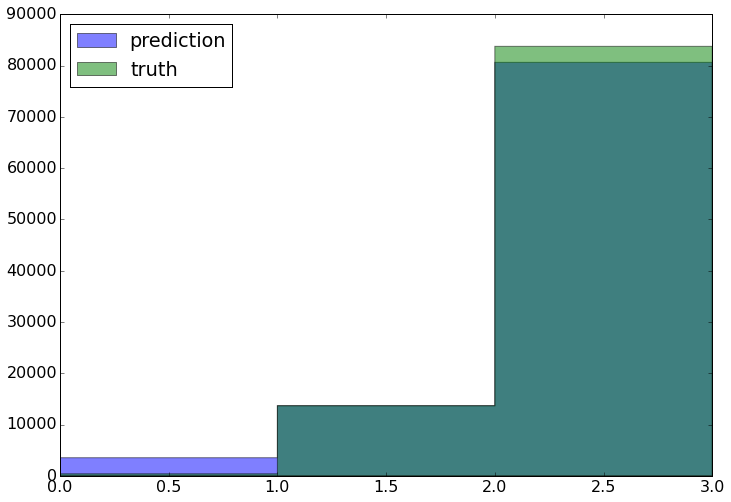

In [34]:
bins = np.linspace(0,3,4)
fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
_ = plt.hist(yhat_cls, bins=bins, histtype='stepfilled', alpha=0.5, label='prediction', weights=w_test)
_ = plt.hist(y_test, bins=bins, histtype='stepfilled', alpha=0.5, label='truth', weights=w_test)
plt.legend(loc='upper left')
plt.show()

In [35]:
# signal eff = weighted tpr --> out of all signal events, what % for we classify as signal?
print 'Signal efficiency:', w_test[(y_test == 0) & (yhat_cls == 0)].sum() / w_test[y_test == 0].sum()

# bkg eff = weighted fpr --> out of all bkg events, what % do we classify as signal?
b_eff = w_test[(y_test != 0) & (yhat_cls == 0)].sum() / w_test[y_test != 0].sum()
print 'Background efficiency:', b_eff
print 'Background rej:', 1 / b_eff

Signal efficiency: 0.948433
Background efficiency: 0.0323833
Background rej: 30.8801244429


In [42]:
# -- events that got assigned to class 0
predicted_ttbar = df_full.ix[np.array(ix_test)[np.argmax(yhat, axis=1) == 0]]

In [43]:
predicted_ttbar

,NJet,Jet_Px,Jet_Py,Jet_Pz,Jet_E,Jet_btag,Jet_ID,NMuon,Muon_Px,Muon_Py,...,MClepton_px,MClepton_py,MClepton_pz,MCleptonPDGid,MCneutrino_px,MCneutrino_py,MCneutrino_pz,NPrimaryVertices,triggerIsoMu24,EventWeight
3137,3,"[10.5899, 29.1949, 46.3157]","[88.7818, -79.5922, 19.1439]","[74.7798, -26.8688, 11.1141]","[118.08, 90.3315, 52.5669]","[-1.0, -1.0, -1.0]","[True, True, True]",1,[-27.6817],[-20.7717],...,-41.461113,-30.952774,11.364951,-15,1.860348,37.448864,16.019556,8,True,0.160826
12791,2,"[-66.5799, 15.8427]","[-29.0298, -36.8908]","[-247.191, 30.3378]","[257.854, 52.1315]","[-1.0, -1.0]","[True, True]",1,[-19.1028],[66.5443],...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,5,True,0.518289
3269,4,"[58.2015, -37.3736, -52.4877, 22.3738]","[46.2129, -50.0838, 3.41034, 23.5898]","[63.3553, 12.2929, 16.2285, -37.9332]","[98.172, 64.4055, 57.303, 50.3862]","[3.09588, 4.07714, -1.0, -1.0]","[True, True, True, True]",1,[-12.5466],[-25.2033],...,-12.788174,-25.674509,-75.284775,-13,52.247398,10.421369,-37.191292,4,True,0.279545
149703,1,[286.041],[-131.665],[-176.492],[366.539],[-1.0],[True],1,[-84.2008],[53.4671],...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,4,True,2.470747
154219,2,"[-113.13, 26.9593]","[45.734, -22.8762]","[-466.691, -81.9326]","[482.695, 89.5966]","[-1.0, 2.66816]","[True, True]",1,[91.6018],[-1.1291],...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,4,True,2.470747
25175,2,"[-97.504, 47.9536]","[40.583, 58.219]","[45.1482, 77.048]","[115.301, 108.194]","[-1.0, -1.0]","[True, True]",1,[65.6432],[-100.132],...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,7,True,0.540515
2229,3,"[-75.3461, 59.3037, 50.5643]","[-46.2092, 33.0899, -37.3384]","[-24.7802, 34.673, -3.78997]","[92.3777, 76.7224, 64.2821]","[1.49563, 1.45435, -1.0]","[True, True, True]",1,[-59.7076],[-23.4328],...,-62.092049,-23.721035,-113.494827,-13,-34.609699,41.513744,-123.405724,6,True,0.279545
59217,0,[],[],[],[],[],[],1,[-8.20722],[29.9897],...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,5,True,0.554355
156109,1,[-33.281],[-70.0906],[-3.07905],[78.4439],[-1.0],[True],1,[44.7094],[-8.79141],...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,13,True,0.907879
2890,3,"[10.7262, -49.739, 47.4295]","[-78.0647, 37.195, -31.0306]","[116.844, 167.101, 89.8167]","[141.736, 178.449, 106.518]","[2.6324, 4.4172, -1.0]","[True, True, True]",1,[-44.7346],[-3.19858],...,-46.203079,-3.024605,77.758369,-13,23.597338,25.888012,114.532036,8,True,0.293189


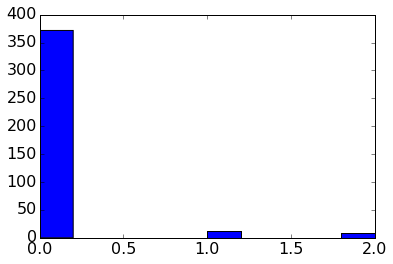

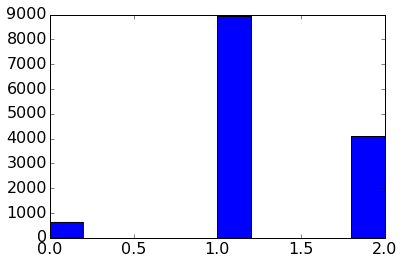

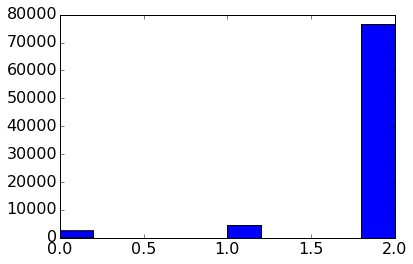

In [40]:
# -- where all ttbar examples assigned to class 0?
for classID in np.unique(y_test):
    plt.hist(np.argmax(yhat[y_test == classID], axis=1), weights=w_test[y_test == classID])
    plt.show()

In [41]:
sum(w_test[(np.argmax(yhat, axis=1) !=0) & (y_test == 0)])

20.203503487631679

## 2. Recurrent Neural Networks

Let's look at a fancier way of solving the same classification problem. In this case we will use Recurrent Neural Netwroks. These allow you to process variable length sequences of data. For example, we can use them to describe an event in terms of the properties of its jets, whose number varies event by event. We could also describe the same event using the properties of its muons, or any other particle that appears in it. Because the number of particles of each type changes in each event, we need the flexibility of RNNs to process this type of data.

In [44]:
jetvars = [key for key in df_full.keys() if key.startswith('Jet')]
jetvars.remove('Jet_ID')
print jetvars

muonvars = [key for key in df_full.keys() if key.startswith('Muon')]
print muonvars

photonvars = [key for key in df_full.keys() if key.startswith('Photon')]
print photonvars

electronvars = [key for key in df_full.keys() if key.startswith('Electron')]
print electronvars

['Jet_Px', 'Jet_Py', 'Jet_Pz', 'Jet_E', 'Jet_btag']
['Muon_Px', 'Muon_Py', 'Muon_Pz', 'Muon_E', 'Muon_Charge', 'Muon_Iso']
['Photon_Px', 'Photon_Py', 'Photon_Pz', 'Photon_E', 'Photon_Iso']
['Electron_Px', 'Electron_Py', 'Electron_Pz', 'Electron_E', 'Electron_Charge', 'Electron_Iso']


In [45]:
df_jets = df_full[jetvars].copy()
df_electrons = df_full[electronvars].copy()
df_muons = df_full[muonvars].copy()
df_photons = df_full[photonvars].copy()

In [46]:
num_electrons = max([len(e) for e in df_electrons.Electron_E])
num_electrons

2

In [47]:
num_muons = max([len(m) for m in df_muons.Muon_E])
num_muons

3

In [48]:
num_photons = max([len(gam) for gam in df_photons.Photon_E])
num_photons

2

In [49]:
num_jets = max([len(j) for j in df_jets.Jet_E])
num_jets

9

Since I'm not going to retrain this net right now but I'm just loading in some pre-trained weights, I will also need to load the exact ordering of indices that I used the time I trained. This way, I will ensure that the random shuffling in `train_test_split` will not cause me to evaluate on a subset of examples I previously trained on.

In [50]:
import cPickle
ix_train, ix_test = cPickle.load(open('ixtraintest.pkl', 'rb'))
X_train, y_train, w_train = X[ix_train], y[ix_train], w[ix_train]
X_test, y_test, w_test = X[ix_test], y[ix_test], w[ix_test]

Just for the sake of variety, you can either have class labels like (0, 1, 2, 3, ...) and train using `spare_categorical_crossentropy` as you loss function -- like we did before -- or, equivalently, you can have class labels like ([1, 0, 0, 0, ...], [0, 1, 0, 0, ...], ...) and train using `categorical_crossentropy`.

In [51]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train

array([[ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.]])

In [61]:
def create_stream(df, num_obj, sort_col):
   
    n_variables = df.shape[1]
    var_names = df.keys()

    data = np.zeros((df.shape[0], num_obj, n_variables), dtype='float32')

    # -- call functions to build X (a.k.a. data)                                                                                                                                                                      
    sort_objects(df, data, sort_col, num_obj)
    
    # -- ix_{train, test} from above or from previously stored ordering
    Xobj_train = data[ix_train]
    Xobj_test = data[ix_test]
    
    #print 'Scaling features ...'
    scale(Xobj_train, var_names, savevars=True) # scale training sample and save scaling
    scale(Xobj_test, var_names, savevars=False) # apply scaling to test set
    return Xobj_train, Xobj_test

In [62]:
def sort_objects(df, data, SORT_COL, max_nobj):
    ''' 
    sort objects using your preferred variable
    
    Args:
    -----
        df: a dataframe with event-level structure where each event is described by a sequence of jets, muons, etc.
        data: an array of shape (nb_events, nb_particles, nb_features)
        SORT_COL: a string representing the column to sort the objects by
        max_nobj: number of particles to cut off at. if >, truncate, else, -999 pad
    
    Returns:
    --------
        modifies @a data in place. Pads with -999
    
    '''
    import tqdm
    # i = event number, event = all the variables for that event 
    for i, event in tqdm.tqdm(df.iterrows(), total=df.shape[0]): 

        # objs = [[pt's], [eta's], ...] of particles for each event 
        objs = np.array(
                [v.tolist() for v in event.get_values()], 
                dtype='float32'
            )[:, (np.argsort(event[SORT_COL]))[::-1]]

        # total number of tracks per jet      
        nobjs = objs.shape[1] 

        # take all tracks unless there are more than n_tracks 
        data[i, :(min(nobjs, max_nobj)), :] = objs.T[:(min(nobjs, max_nobj)), :] 

        # default value for missing tracks 
        data[i, (min(nobjs, max_nobj)):, :  ] = -999 

In [63]:
def scale(data, var_names, savevars, VAR_FILE_NAME='scaling.json'):
    ''' 
    Args:
    -----
        data: a numpy array of shape (nb_events, nb_particles, n_variables)
        var_names: list of keys to be used for the model
        savevars: bool -- True for training, False for testing
                  it decides whether we want to fit on data to find mean and std 
                  or if we want to use those stored in the json file 
    
    Returns:
    --------
        modifies data in place, writes out scaling dictionary
    '''
    import json
    
    scale = {}
    if savevars: 
        for v, name in enumerate(var_names):
            #print 'Scaling feature %s of %s (%s).' % (v + 1, len(var_names), name)
            f = data[:, :, v]
            slc = f[f != -999]
            m, s = slc.mean(), slc.std()
            slc -= m
            slc /= s
            data[:, :, v][f != -999] = slc.astype('float32')
            scale[name] = {'mean' : float(m), 'sd' : float(s)}
            
        with open(VAR_FILE_NAME, 'wb') as varfile:
            json.dump(scale, varfile)

    else:
        with open(VAR_FILE_NAME, 'rb') as varfile:
            varinfo = json.load(varfile)

        for v, name in enumerate(var_names):
            #print 'Scaling feature %s of %s (%s).' % (v + 1, len(var_names), name)
            f = data[:, :, v]
            slc = f[f != -999]
            m = varinfo[name]['mean']
            s = varinfo[name]['sd']
            slc -= m
            slc /= s
            data[:, :, v][f != -999] = slc.astype('float32')

In [64]:
Xjet_train, Xjet_test = create_stream(df_jets, num_jets, sort_col='Jet_btag')

100%|██████████| 191981/191981 [00:16<00:00, 11382.17it/s]


In [65]:
Xphoton_train, Xphoton_test = create_stream(df_photons, num_photons, sort_col='Photon_E')

100%|██████████| 191981/191981 [00:18<00:00, 10430.26it/s]


In [66]:
Xmuon_train, Xmuon_test = create_stream(df_muons, num_muons, sort_col='Muon_E')

100%|██████████| 191981/191981 [00:18<00:00, 10177.36it/s]


In [67]:
Xelectron_train, Xelectron_test = create_stream(df_electrons, num_electrons, sort_col='Electron_E')

100%|██████████| 191981/191981 [00:17<00:00, 11093.29it/s]


In [68]:
from keras.layers import Masking, GRU, Merge

In [69]:
jet_channel = Sequential()
muon_channel = Sequential()
electron_channel = Sequential()
photon_channel = Sequential()

In [70]:
JET_SHAPE = Xjet_train.shape[1:]
MUON_SHAPE = Xmuon_train.shape[1:]
ELECTRON_SHAPE = Xelectron_train.shape[1:]
PHOTON_SHAPE = Xphoton_train.shape[1:]

In [71]:
jet_channel.add(Masking(mask_value=-999, input_shape=JET_SHAPE, name='jet_masking'))
jet_channel.add(GRU(25, name='jet_gru'))
jet_channel.add(Dropout(0.3, name='jet_dropout'))

muon_channel.add(Masking(mask_value=-999, input_shape=MUON_SHAPE, name='muon_masking'))
muon_channel.add(GRU(10, name='muon_gru'))
muon_channel.add(Dropout(0.3, name='muon_dropout'))

electron_channel.add(Masking(mask_value=-999, input_shape=ELECTRON_SHAPE, name='electron_masking'))
electron_channel.add(GRU(10, name='electron_gru'))
electron_channel.add(Dropout(0.3, name='electron_dropout'))

photon_channel.add(Masking(mask_value=-999, input_shape=PHOTON_SHAPE, name='photon_masking'))
photon_channel.add(GRU(10, name='photon_gru'))
photon_channel.add(Dropout(0.3, name='photon_dropout'))

In [72]:
combined_rnn = Sequential()

combined_rnn.add(Merge([
            jet_channel, muon_channel, electron_channel, photon_channel
        ], mode='concat'))

combined_rnn.add(Dense(64, activation = 'relu'))
combined_rnn.add(Dropout(0.3))
combined_rnn.add(Highway(activation = 'relu'))
combined_rnn.add(Dropout(0.3))
combined_rnn.add(Highway(activation = 'relu'))
combined_rnn.add(Dropout(0.3))
combined_rnn.add(Dense(3, activation='softmax'))

In [73]:
combined_rnn.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
jet_masking (Masking)              (None, 9, 5)        0           masking_input_1[0][0]            
____________________________________________________________________________________________________
jet_gru (GRU)                      (None, 25)          2325        jet_masking[0][0]                
____________________________________________________________________________________________________
jet_dropout (Dropout)              (None, 25)          0           jet_gru[0][0]                    
____________________________________________________________________________________________________
muon_masking (Masking)             (None, 3, 6)        0           masking_input_2[0][0]            
___________________________________________________________________________________________

In [74]:
combined_rnn.compile('adam', 'categorical_crossentropy')

In [147]:
print 'Training:'
try:
    combined_rnn.fit([Xjet_train, Xmuon_train, Xelectron_train, Xphoton_train], y_train, batch_size=16,
            class_weight={
                0 : 0.33 * (float(len(y)) / (y == 0).sum()),
                1 : 0.33 * (float(len(y)) / (y == 1).sum()),
                2 : 0.33 * (float(len(y)) / (y == 2).sum())
        },
        callbacks = [
            EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
            ModelCheckpoint('combinedrnn_tutorial-progress', monitor='val_loss', verbose=True, save_best_only=True)
        ],
    nb_epoch=30, 
    validation_split = 0.2) 

except KeyboardInterrupt:
    print 'Training ended early.'

Training:


/usr/local/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/compile/function_module.py:1451: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  optimizer_profile = optimizer(fgraph)


Train on 92150 samples, validate on 23038 samples
Epoch 1/30
92150/92150 [==============================] - 333s - loss: 0.5269 - val_loss: 0.3867
Epoch 2/30
92150/92150 [==============================] - 305s - loss: 0.4164 - val_loss: 0.3797
Epoch 3/30
92150/92150 [==============================] - 305s - loss: 0.4033 - val_loss: 0.3790
Epoch 4/30
92150/92150 [==============================] - 294s - loss: 0.3990 - val_loss: 0.3806
Epoch 5/30
92150/92150 [==============================] - 316s - loss: 0.3984 - val_loss: 0.3885
Epoch 6/30
 7248/92150 [=>............................] - ETA: 312s - loss: 0.3733Training ended early.


In [75]:
# -- load in best network
combined_rnn.load_weights('combinedrnn_tutorial-progress')
print 'Saving weights...'
combined_rnn.save_weights('./combinedrnn_tutorial.h5', overwrite=True)

json_string = combined_rnn.to_json()
open('combinedrnn_tutorial.json', 'w').write(json_string)

Saving weights...


In [76]:
yhat_rnn = combined_rnn.predict([Xjet_test, Xmuon_test, Xelectron_test, Xphoton_test], verbose = True, batch_size = 512) 

76793/76793 [==============================] - 2s     


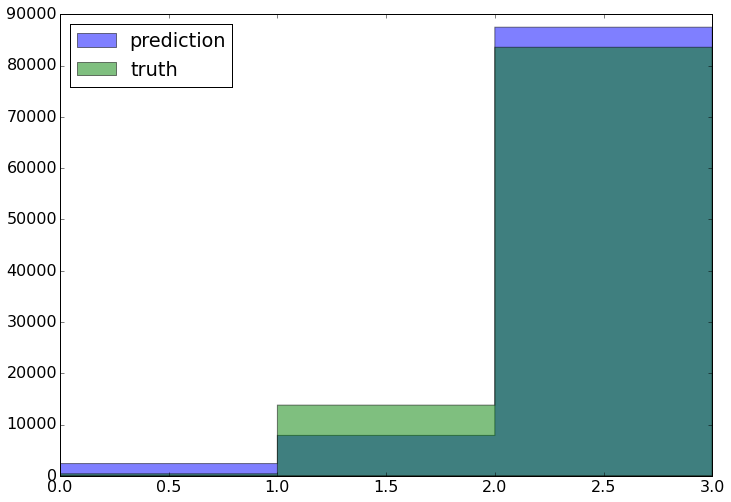

In [77]:
bins = np.linspace(0,3,4)
fig = plt.figure(figsize=(11.69, 8.27), dpi=100)
_ = plt.hist(np.argmax(yhat_rnn, axis=1), bins=bins, histtype='stepfilled', alpha=0.5, label='prediction', weights=w_test)
_ = plt.hist(y_test.argmax(axis=1), bins=bins, histtype='stepfilled', alpha=0.5, label='truth', weights=w_test)
plt.legend(loc='upper left')
plt.show()

In [78]:
# -- turn the predictions back into class labels
yhat_rnn_cls = np.argmax(yhat_rnn, axis=1)
yhat_rnn_cls

In [80]:
# -- do the same for the truth labels
y_test_cls = np.argmax(y_test, axis=1)

In [81]:
print 'Signal efficiency:', w_test[(y_test_cls == 0) & (yhat_rnn_cls == 0)].sum() / w_test[y_test_cls == 0].sum()

Signal efficiency: 0.946364


In [82]:
b_eff = w_test[(y_test_cls != 0) & (yhat_rnn_cls == 0)].sum() / w_test[y_test_cls != 0].sum()
print 'Background efficiency:', b_eff
print 'Background rej:', 1 / b_eff

Background efficiency: 0.0206689
Background rej: 48.3818910531


# Keras Functional API

In [90]:
from keras.layers import Input, merge
from keras.models import Model

In [98]:
# here is the functional API if interested 

# create placeholders
jet = Input(shape=JET_SHAPE, name='jet_input')
muon = Input(shape=MUON_SHAPE, name='muon_input')
electron = Input(shape=ELECTRON_SHAPE, name='electron_input')
photon = Input(shape=PHOTON_SHAPE, name='photon_input')

event     = [jet,     muon,    electron, photon]
rnn_specs = [GRU(25), GRU(10), GRU(10),  GRU(10)]

masked_event = [Masking(mask_value=-999)(obj) for obj in event]

y = Dropout(0.3)(merge([
            rnn(ev) for rnn, ev in zip(rnn_specs, masked_event)
        ], mode='concat'))

mapping = [Dense(64, activation='relu'), 
           Dropout(0.3), 
           Highway(activation='relu'), 
           Dropout(0.3), 
           Highway(activation='relu'), 
           Dropout(0.3), 
           Dense(3, activation='softmax')]

for L in mapping:
    y = L(y)

net = Model(input=event, output=y)

In [99]:
net.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
electron_input (InputLayer)        (None, 2, 6)        0                                            
____________________________________________________________________________________________________
jet_input (InputLayer)             (None, 9, 5)        0                                            
____________________________________________________________________________________________________
muon_input (InputLayer)            (None, 3, 6)        0                                            
____________________________________________________________________________________________________
photon_input (InputLayer)          (None, 2, 5)        0                                            
___________________________________________________________________________________________